<img src="images/celo.png" style="width:1000px;height:150px;">


This was a Kaggle competition, which aimed to develop machine learning algorithms to identify and serve the most relevant opportunities for individuals, revealing a sign of customer loyalty. Improve customer’s experience by proposing strategies to help Elo reduce unwanted campaigns to groups of customers is also explored. (https://www.kaggle.com/c/elo-merchant-category-recommendation ). 

In this report/code a very detailed solution is presented. Tools used are presented and key strategic data analysis functions are explained. The solution has some functions/strategies also used by Chau Ngoc Huynh’s kernel. The intention is to make the explanation more accessible to people who are starting to study Data Science / Machine Learning. We believe that through this file some people can learn a bit how to manipulate data, start a contact with one Machine Learning model, and get used to search the libraries and the methods used.

In [7]:
import numpy as np
import pandas as pd
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

### If you are interested in knowing a bit more about each of the libraries and modules used, please check summary below:

<img src="images/introduction.PNG" style="width:1000px;height:650px;">



### Links/References available at :
- [NumPy](https://docs.scipy.org/doc/numpy-1.12.0/reference/index.html)
- [Pandas](pandas.pydata.org/pandas-docs/stable/) 
- [datetime](https://docs.python.org/3/library/datetime.html#module-datetime)
- [gc](https://docs.python.org/2/library/gc.html)
- [matplotlib.pyplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot)
- [Seaborn](https://seaborn.pydata.org/) 
- [LightGBM](https://lightgbm.readthedocs.io/en/latest/genindex.html)
- [Scikit-learn](https://scikit-learn.org/stable/)
- [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), 
- [Mean Squared Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html). 

**Converting "Comma Separated Values" (CSV) file into a DataFrame:**

In [8]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_hist_trans = pd.read_csv('historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('new_merchant_transactions.csv')

**Applying `df.head(n)`, which will return the first "n" rows. `IPython.display` is used in order to make possible to see all information in only one cell:**

In [9]:
display(df_train.head(2))
display(df_hist_trans.head(2))
display(df_test.head(2))
display(df_new_merchant_trans.head(2))

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04,C_ID_0ab67a22ab,3,3,1
1,2017-01,C_ID_130fd0cbdd,2,3,0


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19


**The `df.info( )` method is useful to get a data description from a data frame, in particular, the total number of rows, each attribute’s type and number of non-null values:**

In [10]:
display(df_train.info())
display(df_hist_trans.info())
display(df_test.info())
display(df_new_merchant_trans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null object
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: int64(3), object(2)
memory usage: 4.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


None

**At this point, an analysis over missing values in each data frame is performed. An anonymous function, also known as $\lambda $ *(lambda)* functions was elaborated to point it out the quantity of null values in each data set. The syntax of Lambda function in python is `lambda arguments: expression`. In our case, we applied:**

```python
df.apply(lambda x: sum(x.isnull()), axis=0)
```

**Ps. It is possible to use different methods to measure null values (missing values) in a data frame, which means that it is not necessary to create a *lambda* function for that. However, in our study we did elaborated that mainly because we are aiming to have a simple and understandable code.**

In [11]:
dic = {'df_train': df_train, 'df_test': df_test, 'df_hist_trans': df_hist_trans, 'df_new_merchant_trans': df_new_merchant_trans }
for name, df in dic.items():
    print("-------" + name + "-------")
    print(df.apply(lambda x: sum(x.isnull()), axis=0)) #axis=0 define que a função deve ser aplicada em cada coluna

-------df_train-------
first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64
-------df_test-------
first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64
-------df_hist_trans-------
authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64
-------df_new_merchant_trans-------
authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments    

**In the data frame `df_test`, only one value was lost, located in the "first_active_month" column. Approach followed in this case was remove the row that have this missing value. For more information regarding function used to do that, please see:** [pandas.DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).

In [12]:
# drop rows with missing values
df_test.dropna(inplace=True)

**For the other data frames (that presented a significant amount of missing values per data set), replace the missing value followed a different approach. The mode (most frequent value in a range) of each collum took the place of the missing values. In order to do that, it is first necessary to know the most frequent value in each case, `df[columns].mode()` was used and results are presented below:**

In [13]:
dic = {'df_hist_trans': df_hist_trans, 'df_new_merchant_trans': df_new_merchant_trans}
for name, df in dic.items():
    for columns in ('category_2', 'category_3','merchant_id' ):
        print('The value that appears most often in column ' + columns + ' of the ' + name)
        print(df[columns].mode())

The value that appears most often in column category_2 of the df_hist_trans
0    1.0
dtype: float64
The value that appears most often in column category_3 of the df_hist_trans
0    A
dtype: object
The value that appears most often in column merchant_id of the df_hist_trans
0    M_ID_00a6ca8a8a
dtype: object
The value that appears most often in column category_2 of the df_new_merchant_trans
0    1.0
dtype: float64
The value that appears most often in column category_3 of the df_new_merchant_trans
0    A
dtype: object
The value that appears most often in column merchant_id of the df_new_merchant_trans
0    M_ID_00a6ca8a8a
dtype: object


**Now, `fillna` method is applied to fill up the columns. In order to do that, the mode and data set have to be mention in the code:**

In [14]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

**An analysis over the "target" column in the `df_train` dataframe is performed. The aim of this analysis is to verify the existence of outliers. A simple method to do that is plot its histogram, in order to do that we used `plot.hist`:**

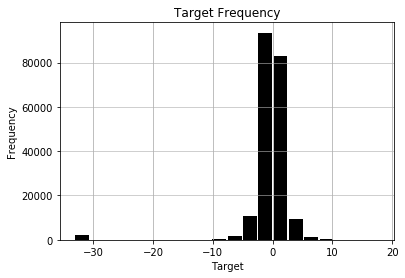

In [15]:
df_train['target'].plot.hist(grid=True, bins=20, rwidth=0.9, color='k')
plt.title('Target Frequency')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

It was possible to see that the interval $[-30,-18]$ does not contain any value. On the other hand, it was observed values up to 18. Therefore, it is possible to justify that any other value less than -18 is an outlier and furthermore, a collum is created (outlier collum) and those values are set as 1.


Analysis can be check using the piece of code below:

```python

In [] len([1 for i in df_train['target'] if i>-30 and i<-18])
Out[] 0
In []len([1 for i in df_train['target'] if i>18]) 
Out[] 0 
```

In [16]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -18, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

**Next two code lines are, first replacing nan observations for category 2, category 3 and merchant ID; second, using first active month to create two new collums with infromation that is presented**  

In [17]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [18]:
for df in [df_train,df_test]:
    df['first_active_month'] =  pd.to_datetime(df['first_active_month'])
    df['activation_month'] = df['first_active_month'].dt.month
    df['activation_year'] = df['first_active_month'].dt.year

**The next two pieces of code intends to create more features through of some features that we have. The idea below was based on ideas presented on kaggle's kernel [My first kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699 ).**

1. Step
Create a function that the arggument is a dictionary to create feature names

2. Step
Define new features

3. Step
Create more features based on features that we just defined

4. Step
Merge all the dataframes (df_hist_trans,df_new_merchant_trans) into test and train (df_train and df_test)

5. Step
Delete the dataframes that will not be use (df_hist_trans,df_new_merchant_trans) 

In [19]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [20]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0})

In [21]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['card_id'] = ['size']

for col in ['category_1', 'category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs) # filling the values
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()
    

120

In [22]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['card_id'] = ['size']

for col in ['category_1', 'category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

81

**In the following lines of code, target (as a feature) is removed from train data set:**

In [23]:
target = df_train['target']
del df_train['target']

**The following pieces of code does present the definition of a correlation matrix between variables. And all variables that present correlation over than 0.9 is removed from train and test data set. After this process the matrix is plotted one more time to verify that process work it out:**

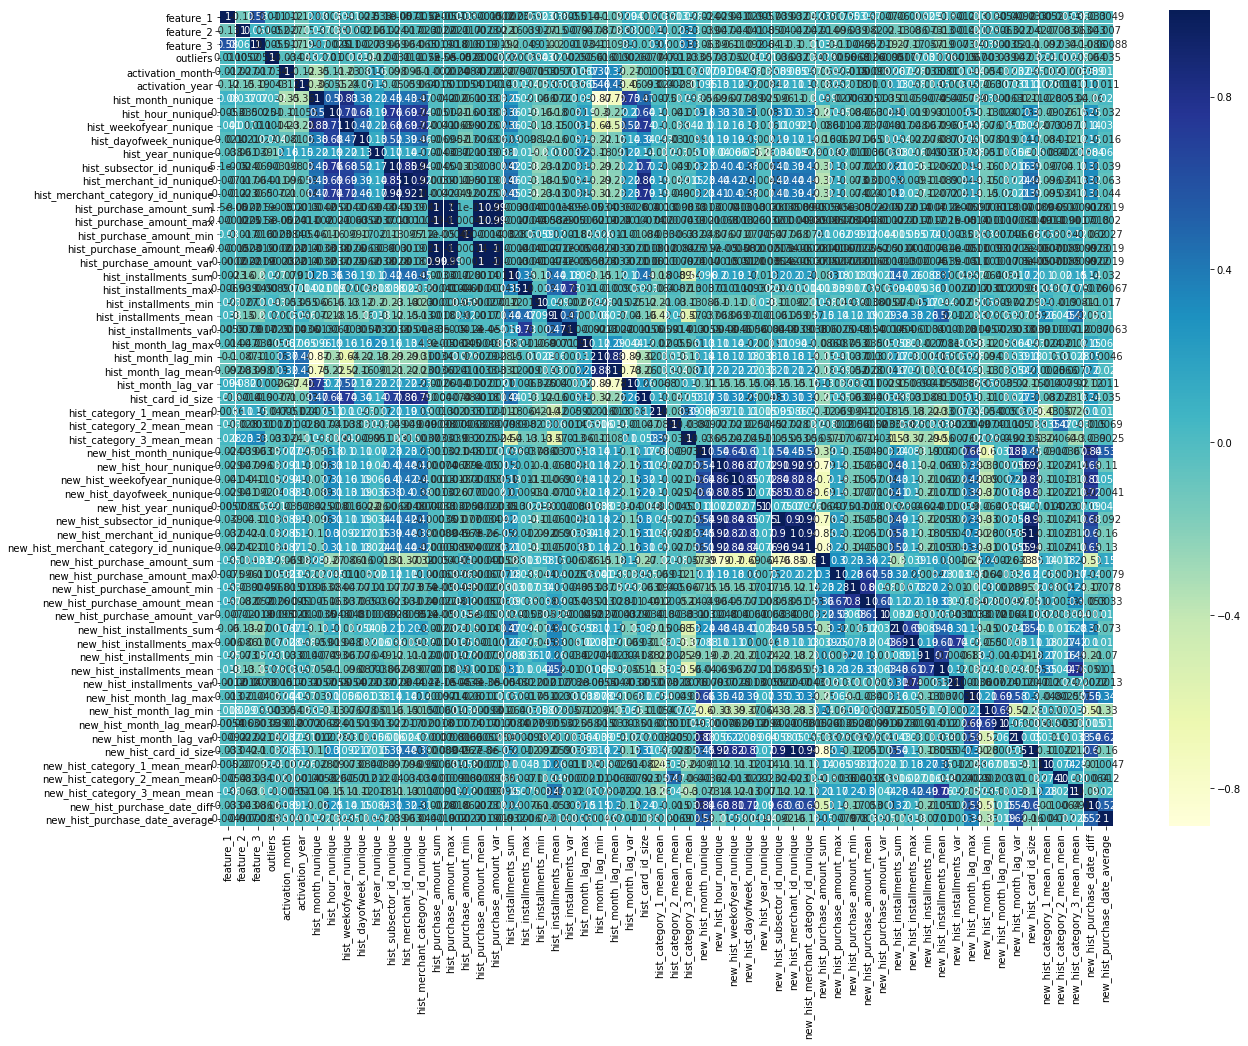

In [24]:
fig, (axis1) = plt.subplots(1,1,figsize=(20,15))
# df.corr() Compute pairwise correlation of columns, excluding NA/null values.
# sns.heatmap() Plot rectangular data as a color-encoded matrix.
sns.heatmap(df_train.corr(),annot=True,linewidths=0.001,cmap="YlGnBu")

In [25]:
def feature_correlated(df_in, threshold):
   df_corr = df_in.corr(method='pearson', min_periods=1)

   # np.ones() Return a new array of given shape and type, filled with ones.
   # np.tril() Return a copy of an array with elements above the diagonal equal False.
   # df.mask() Replace values where the condition is False.
    
   serie_not_correlated = ~(df_corr.mask(np.tril(np.ones(df_corr.shape, dtype=bool))).abs() > threshold).any()
   column_corr_idx = serie_not_correlated.loc[serie_not_correlated == True].index
   df_out = df_in[column_corr_idx]
   return df_out

In [26]:
df_train = feature_correlated(df_train, 0.9)
df_train_columns = [c for c in df_train.columns if c not in ['card_id','target','outliers']]


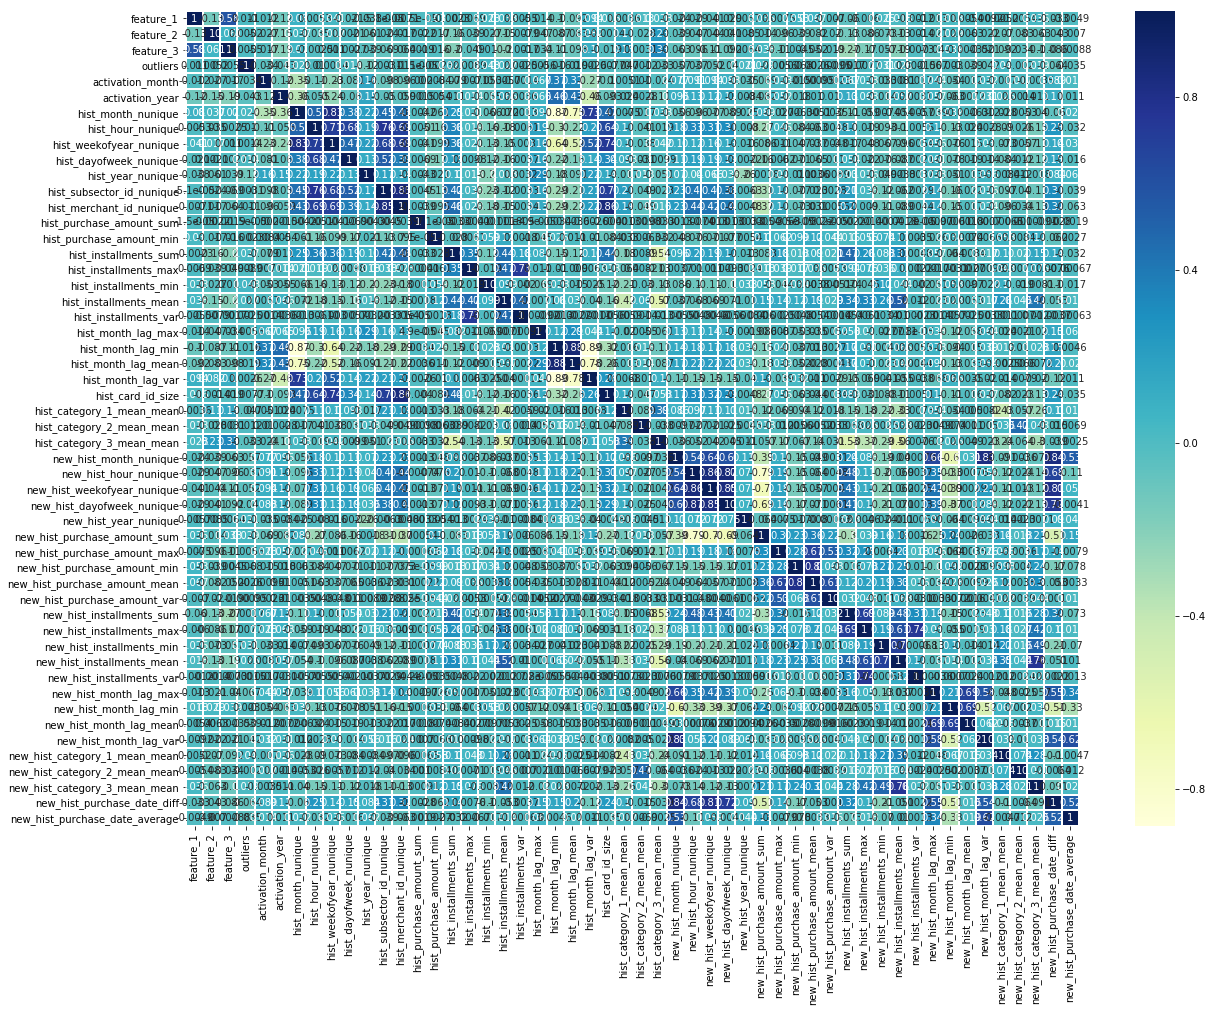

In [27]:
fig, (axis1) = plt.subplots(1,1,figsize=(20,15))
sns.heatmap(df_train.corr(),annot=True,linewidths=1,cmap="YlGnBu")

** `LightGBM` is the Model selected to train and apply ML at the test data set. It is supervised learning recommended to problems that has large data sets. **

** If `LightGBM` is new for you and you would like to know about it one good reference is the article [What is LightGBM](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) by Pushkar Mandot. **

In [28]:
# Parameters https://lightgbm.readthedocs.io/en/latest/Parameters.html
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.6859	valid_1's rmse: 3.73475
[200]	training's rmse: 3.62038	valid_1's rmse: 3.70137
[300]	training's rmse: 3.58252	valid_1's rmse: 3.68806
[400]	training's rmse: 3.55382	valid_1's rmse: 3.6802
[500]	training's rmse: 3.52922	valid_1's rmse: 3.67508
[600]	training's rmse: 3.50905	valid_1's rmse: 3.67216
[700]	training's rmse: 3.49146	valid_1's rmse: 3.67005
[800]	training's rmse: 3.47546	valid_1's rmse: 3.66827
[900]	training's rmse: 3.46136	valid_1's rmse: 3.66754
[1000]	training's rmse: 3.44871	valid_1's rmse: 3.667
[1100]	training's rmse: 3.43646	valid_1's rmse: 3.66609
[1200]	training's rmse: 3.42327	valid_1's rmse: 3.66559
[1300]	training's rmse: 3.41132	valid_1's rmse: 3.66551
[1400]	training's rmse: 3.39976	valid_1's rmse: 3.66513
[1500]	training's rmse: 3.38762	valid_1's rmse: 3.66554
Early stopping, best iteration is:
[1412]	training's rmse: 3.39791	valid_1's rmse: 3.66503
fold 1
Train

3.665110510834025

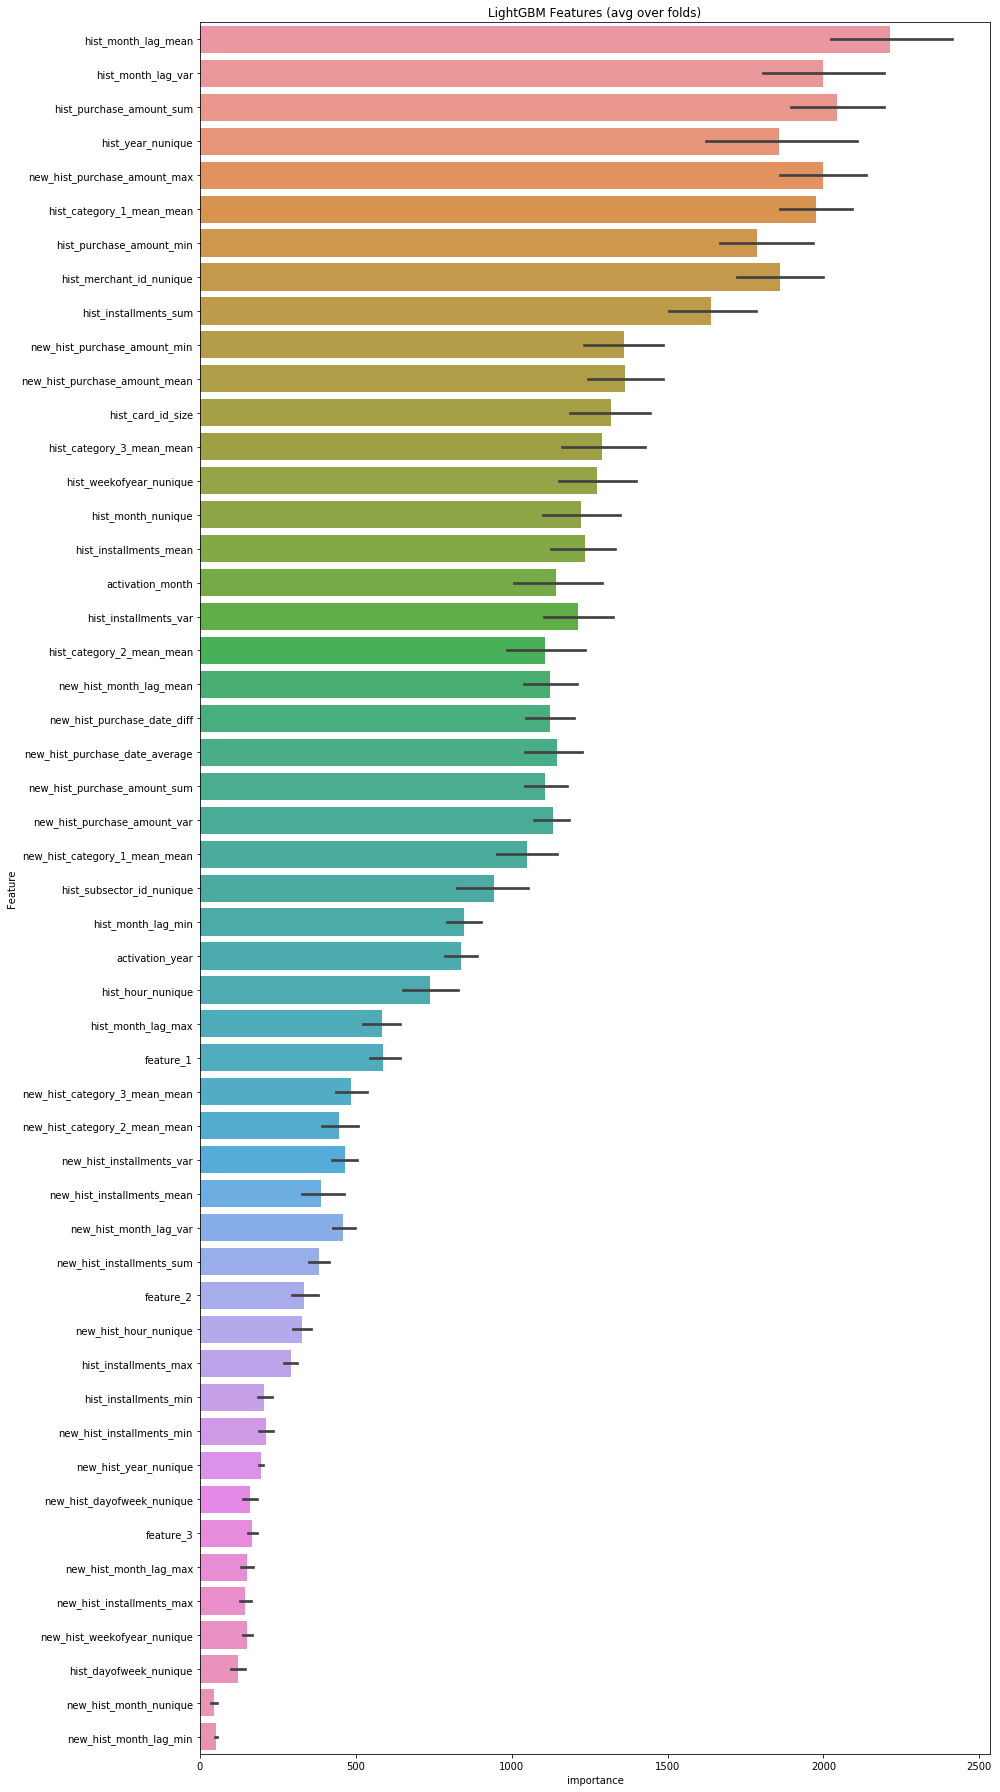

In [29]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [44]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [49]:
sub1_df = pd.merge(df_test, sub_df, on='card_id')
sub1_df.to_csv("submission1.csv", index=False)

In [50]:
display(sub1_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123622 entries, 0 to 123621
Data columns (total 66 columns):
first_active_month                       123622 non-null datetime64[ns]
card_id                                  123622 non-null object
feature_1                                123622 non-null int64
feature_2                                123622 non-null int64
feature_3                                123622 non-null int64
activation_month                         123622 non-null int64
activation_year                          123622 non-null int64
hist_month_nunique                       123622 non-null int64
hist_hour_nunique                        123622 non-null int64
hist_weekofyear_nunique                  123622 non-null int64
hist_dayofweek_nunique                   123622 non-null int64
hist_year_nunique                        123622 non-null int64
hist_subsector_id_nunique                123622 non-null int64
hist_merchant_id_nunique                 123622 non-null int

None

In [53]:
display(sub1_df.head())

,first_active_month,card_id,feature_1,feature_2,feature_3,activation_month,activation_year,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,...,new_hist_month_lag_min,new_hist_month_lag_mean,new_hist_month_lag_var,new_hist_card_id_size,new_hist_category_1_mean_mean,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,target
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,4,2017,9,17,24,...,2.0,2.000000,0.000000,3.0,-0.562004,-0.550160,-0.391755,25.0,8.333333,-2.867550
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,1,2017,5,18,20,...,1.0,1.444444,0.277778,9.0,-0.485708,-0.555930,-0.534909,48.0,5.333333,-0.445914
2,2017-08-01,C_ID_b709037bc5,5,1,1,8,2017,6,7,7,...,1.0,1.000000,0.000000,2.0,-0.390338,-0.549587,-0.284389,11.0,5.500000,-0.717315
3,2017-12-01,C_ID_d27d835a9f,2,1,0,12,2017,3,9,6,...,1.0,1.300000,0.233333,10.0,-0.527671,-0.550046,-0.284389,44.0,4.400000,-0.104748
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,12,2015,12,21,34,...,1.0,1.166667,0.166667,6.0,-0.562004,-0.556457,-0.496872,39.0,6.500000,-1.192615
